In [107]:
import numpy as np
import pickle
import matplotlib.pylab as plt
%matplotlib inline

# parameters
wvc = 20.0
aot = 0.1
press = 1013.0
alt = 0.0
sol_zen = 20.0
sat_zen = 0.0
rel_azi = 0.0

# dictionary file
fn = '/home/malapradej/Documents/PhD_UCL/Data/LUT/quick/quick_clds_dasf/20/0/0/0.0_0.1_20_1013.p'

dic = pickle.load(open(fn, 'rb'))

In [108]:
dic

{'AOT': 0.1,
 'WVC': 20.0,
 'alt': 0.0,
 'atm_path': array([ 0.04174216,  0.04174216,  0.04174216, ...,  0.01080293,
         0.01080293,  0.01080293]),
 'dbl_trans': array([ 0.81433824,  0.81433824,  0.81433824, ...,  0.89273472,
         0.89273472,  0.89273472]),
 'lam': array([ 540.  ,  540.05,  540.1 , ...,  799.9 ,  799.95,  800.  ]),
 'press': 1013.0,
 'rel_azi': array(180.0),
 'sat_zen': 0.0,
 'sol_zen': 20.0,
 'spher_alb': array([ 0.1048619 ,  0.1048619 ,  0.1048619 , ...,  0.03393362,
         0.03393362,  0.03393362])}

In [109]:
# to range we need
wl_min = 680
wl_max = 755
ixs = np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)
lam = dic['lam'][ixs]
atm_path = dic['atm_path'][ixs]
dbl_trans = dic['dbl_trans'][ixs]
spher_alb = dic['spher_alb'][ixs]

In [110]:
atm_path

array([ 0.01871495,  0.01871197,  0.0187093 , ...,  0.01336057,
        0.01335919,  0.01335752])

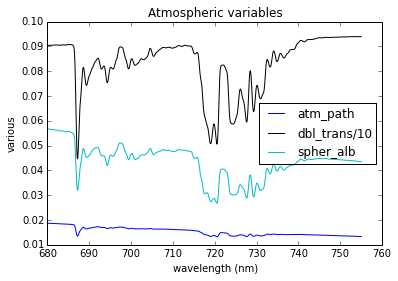

In [111]:
plt.plot(lam, atm_path, 'b-', label='atm_path')
plt.plot(lam, dbl_trans/10, 'k-', label='dbl_trans/10')
plt.plot(lam, spher_alb, 'c-', label='spher_alb')
plt.title('Atmospheric variables')
plt.ylabel('various')
plt.xlabel('wavelength (nm)')
plt.legend(loc='best')
plt.show()

In [112]:
# leaf data
fn = 'leaf_spectrum.txt'
leaf = np.loadtxt(fn).T
leafLambda = leaf[0]
leafAlbedo = leaf[1] + leaf[2]

# reduce the leaf lam and albedo data size (speeds up interpolation...)
xleafFull = leafLambda
leafLambda = xleafFull[(xleafFull>=wl_min) * (xleafFull<=wl_max)]
leafAlbedo = leafAlbedo[(xleafFull>=wl_min) * (xleafFull<=wl_max)]

from scipy.interpolate import interp1d

func = interp1d(leafLambda, leafAlbedo, kind='cubic')
leaf = func(lam)


In [113]:
# fixed canopy parameters
a = 0.12
p = 0.85
BRF = a*leaf / (1 - p*leaf)

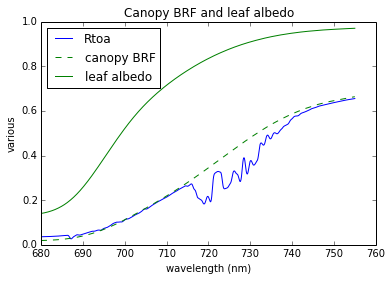

In [114]:
# forward model without clouds
Rtoa = atm_path + BRF*dbl_trans / (1 - spher_alb*BRF)

plt.plot(lam, Rtoa, 'b-', label='Rtoa')
plt.plot(lam, BRF, 'g--', label='canopy BRF')
plt.plot(lam, leaf, 'g-', label='leaf albedo')
plt.title('Canopy BRF and leaf albedo')
plt.ylabel('various')
plt.xlabel('wavelength (nm)')
plt.legend(loc=0)

In [115]:
# seeing if we can retrieve a and p with other parameters fixed

def Rtoa_no_cld(a, p, atm_path, dbl_trans, spher_alb, leaf):
    R = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, Rtoa):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_no_cld(a, p, atm_path, dbl_trans, spher_alb, leaf) - Rtoa
    return np.sum(resid**2)

from scipy.optimize import fmin_bfgs

ap = (0.9, 0.1)
args = (atm_path, dbl_trans, spher_alb, leaf, Rtoa)

result = fmin_bfgs(cost, x0=ap, args=args)
print result

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 148
         Gradient evaluations: 37
[ 0.11999992  0.85000012]


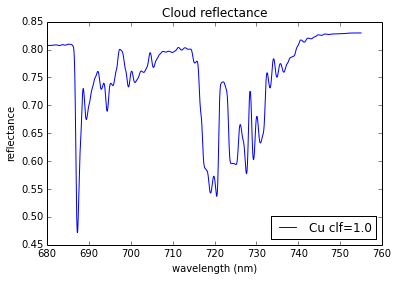

In [116]:
# adding clouds
import pandas as pd
fn = 'cloud_sims.h5'
cld_type = 'Cu'
cld_df = pd.read_hdf(fn, key='reflectance')
temp_df = cld_df[cld_type].icol(0)[np.logical_and(cld_df.index>=wl_min, cld_df.index<=wl_max)]
cld_lam = temp_df.index.values
cld_ref = temp_df.values

#interpolat to lam
func = interp1d(cld_lam, cld_ref, kind='linear')
cld_ref = func(lam)

plt.plot(lam, cld_ref, 'b-', label='%s clf=1.0' %cld_type)
plt.title('Cloud reflectance')
plt.ylabel('reflectance')
plt.xlabel('wavelength (nm)')
plt.legend(loc=0)

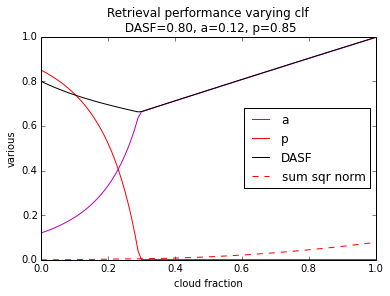

In [136]:
# gradually adding cloud cover and retrieve parameters as we go, see where it falls apart

def Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref):
    R = (1-clf)*(atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))) + clf*cld_ref
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, Rtoa):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_no_cld(a, p, atm_path, dbl_trans, spher_alb, leaf) - Rtoa
    return np.sum(resid**2)

ap = (0.1, 0.9)
bounds = np.array([(0.001,0.999),(0.001,0.999)])

clfs = np.linspace(0, 1, 101, endpoint=True)

from scipy.optimize import fmin_l_bfgs_b

ass = []
pss = []
DASFs = []
sum_sqr = []

for clf in clfs:
    Rtoa_c = Rtoa_clds(a, p, atm_path, dbl_trans, spher_alb, leaf, clf, cld_ref)
    args = (atm_path, dbl_trans, spher_alb, leaf, Rtoa_c)
    result = fmin_l_bfgs_b(cost, x0=ap, args=args, approx_grad=True, bounds=bounds)
    ass.append(result[0][0])
    pss.append(result[0][1])
    DASFs.append(result[0][0]/(1 - result[0][1]))
    sum_sqr.append(result[1])

plt.plot(clfs, ass, 'm-', label='a')
plt.plot(clfs, pss, 'r-', label='p')
plt.plot(clfs, DASFs, 'k-', label='DASF')
plt.plot(clfs, np.array(sum_sqr)/len(lam), 'r--', label='sum sqr norm')
plt.legend(loc=0)
plt.title('Retrieval performance varying clf\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('cloud fraction')
plt.ylabel('various')

In [153]:
# at 10% clf which is what Philipp Kohler uses
mask = np.where(clfs==0.1)[0]
print 'Values at 10%% clf are for a %.3f for p %.3f and DASF %.3f' %(ass[mask], pss[mask], DASFs[mask])
print 'This is a difference wrt true values of for a %.0f%% and p %.0f%% and DASF %.0f%%' %((ass[mask]-a)*100, (pss[mask]-p)*100, (DASFs[mask]-(a/(1-p)))*100)

Values at 10% clf are for a 0.190 for p 0.743 and DASF 0.739
This is a difference wrt true values of for a 7% and p -11% and DASF -6%


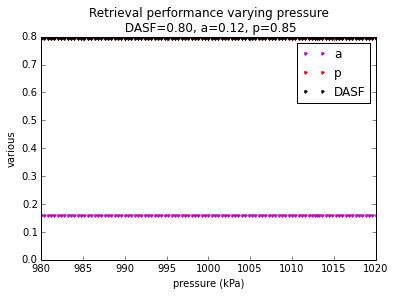

In [126]:
# to test changing pressure on the retrieval of a, p and DASF
import glob
import cPickle
root = '/home/malapradej/Documents/PhD_UCL/Data/LUT/quick/quick_atm_DASF/20.0000/0.0000/0.0000/'
fixed_paras = {'sol_zen':'20.0000', 'sat_zen':'0.0000', 'rel_azi':'0.0000', 'alt':'0.0000', 'aot':'0.1000', 'wvc':'20.0000', 'press':'1013.0000'}
regex = root+fixed_paras['alt']+'_'+fixed_paras['aot']+'_'+fixed_paras['wvc']+'_'+'*'+'.p'
paths = sorted(glob.glob(regex))

def Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf):
    R = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, BRF):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf) - BRF
    return np.sum(resid**2)

ass = []
pss = []
DASFs = []
presss = []
for path in paths:
    dic = cPickle.load(open(path, 'rb'))
    alt = dic['alt']
    aot = dic['AOT']
    wvc = dic['WVC']
    press = dic['press']
    atm_path = dic['atm_path'][np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    dbl_trans = dic['dbl_trans'][np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    spher_alb = dic['spher_alb'][np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    # seeing if we can retrieve a and p with other parameters fixed
    ap = (0.1, 0.9)
    args = (atm_path, dbl_trans, spher_alb, leaf, BRF)
    result = fmin_l_bfgs_b(cost, x0=ap, args=args, approx_grad=True, bounds=bounds)
    ass.append(result[0][0])
    pss.append(result[0][1])
    DASFs.append(result[0][0] / (1 - result[0][1]))
    presss.append(press)

plt.plot(presss, ass, 'm.', label='a')
plt.plot(presss, pss, 'r.', label='p')
plt.plot(presss, DASFs, 'k.', label='DASF')
plt.ylim(0,)
plt.legend(loc=0)
plt.title('Retrieval performance varying pressure\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('pressure (kPa)')
plt.ylabel('various')

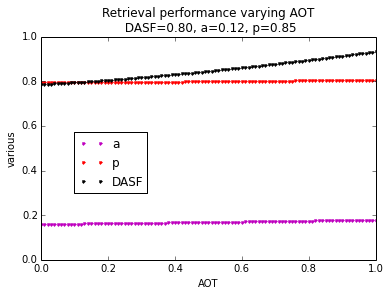

In [128]:
# to test changing aot on the retrieval of a, p and DASF
import glob
import cPickle
root = '/home/malapradej/Documents/PhD_UCL/Data/LUT/quick/quick_atm_DASF/20.0000/0.0000/0.0000/'
fixed_paras = {'sol_zen':'20.0000', 'sat_zen':'0.0000', 'rel_azi':'0.0000', 'alt':'0.0000', 'aot':'0.1000', 'wvc':'20.0000', 'press':'1013.0000'}
regex = root+fixed_paras['alt']+'_'+'*'+'_'+fixed_paras['wvc']+'_'+fixed_paras['press']+'.p'
paths = sorted(glob.glob(regex))

def Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf):
    R = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, BRF):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf) - BRF
    return np.sum(resid**2)

ass = []
pss = []
DASFs = []
aots = []
for path in paths:
    dic = cPickle.load(open(path, 'rb'))
    alt = dic['alt']
    aot = dic['AOT']
    wvc = dic['WVC']
    press = dic['press']
    atm_path = dic['atm_path'][np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    dbl_trans = dic['dbl_trans'][np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    spher_alb = dic['spher_alb'][np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    # seeing if we can retrieve a and p with other parameters fixed
    ap = (0.1, 0.9)
    args = (atm_path, dbl_trans, spher_alb, leaf, BRF)
    result = fmin_l_bfgs_b(cost, x0=ap, args=args, approx_grad=True, bounds=bounds)
    ass.append(result[0][0])
    pss.append(result[0][1])
    DASFs.append(result[0][0] / (1 - result[0][1]))
    aots.append(aot)

plt.plot(aots, ass, 'm.', label='a')
plt.plot(aots, pss, 'r.', label='p')
plt.plot(aots, DASFs, 'k.', label='DASF')
plt.ylim(0,)
plt.legend(loc=(0.1, 0.3))
plt.title('Retrieval performance varying AOT\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('AOT')
plt.ylabel('various')


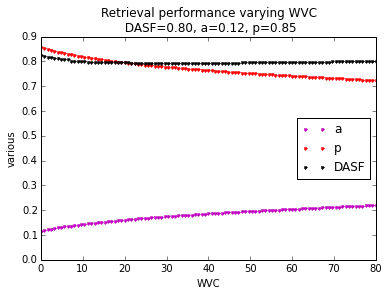

In [129]:
# to test changing wvc on the retrieval of a, p and DASF
import glob
import cPickle
root = '/home/malapradej/Documents/PhD_UCL/Data/LUT/quick/quick_atm_DASF/20.0000/0.0000/0.0000/'
fixed_paras = {'sol_zen':'20.0000', 'sat_zen':'0.0000', 'rel_azi':'0.0000', 'alt':'0.0000', 'aot':'0.1000', 'wvc':'20.0000', 'press':'1013.0000'}
regex = root+fixed_paras['alt']+'_'+fixed_paras['aot']+'_'+'*'+'_'+fixed_paras['press']+'.p'
paths = sorted(glob.glob(regex))

def Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf):
    R = atm_path + dbl_trans * (a*leaf/(1 - p*leaf)) / (1 - spher_alb*(a*leaf/(1 - p*leaf)))
    return R

def cost(ap, atm_path, dbl_trans, spher_alb, leaf, BRF):
    a = ap[0]
    p = ap[1]
    resid = Rtoa_atm(a, p, atm_path, dbl_trans, spher_alb, leaf) - BRF
    return np.sum(resid**2)

ass = []
pss = []
DASFs = []
wvcs = []
for path in paths:
    dic = cPickle.load(open(path, 'rb'))
    alt = dic['alt']
    aot = dic['AOT']
    wvc = dic['WVC']
    press = dic['press']
    atm_path = dic['atm_path'][np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    dbl_trans = dic['dbl_trans'][np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    spher_alb = dic['spher_alb'][np.logical_and(dic['lam']>=wl_min, dic['lam']<=wl_max)]
    # seeing if we can retrieve a and p with other parameters fixed
    ap = (0.1, 0.9)
    args = (atm_path, dbl_trans, spher_alb, leaf, BRF)
    result = fmin_l_bfgs_b(cost, x0=ap, args=args, approx_grad=True, bounds=bounds)
    ass.append(result[0][0])
    pss.append(result[0][1])
    DASFs.append(result[0][0] / (1 - result[0][1]))
    wvcs.append(wvc)

plt.plot(wvcs, ass, 'm.', label='a')
plt.plot(wvcs, pss, 'r.', label='p')
plt.plot(wvcs, DASFs, 'k.', label='DASF')
plt.ylim(0,)
plt.legend(loc=0)
plt.title('Retrieval performance varying WVC\n DASF=%.2f, a=%.2f, p=%.2f' % (a/(1-p),a,p))
plt.xlabel('WVC')
plt.ylabel('various')


All things being equal the WVC and cloud fraction has the largest impact on the performance of the retrieval of DASF, a and p. DASF seems to be immune to large fluctuations in a an p, with a solution quite close to the true value despite large AOT and pressure changes. The largest discrepancies are with cloud fractions and WVC values. WVC has the largest impact on the spectrum in the water vapour absorption band between about 715 nm and 740 nm. Clouds would affect the full spectrum adding to the signal with smaller increments in the water vapour and O2B absorption band which is between approximately 685 nm to 710 nm. Although DASF is reasonably well retrieved, the a and p values show greater variation in their retrieval depending on the parameter. Once again clouds affect the retrieval of a and p most, followed by WVC, AOT, and pressure. 

In [ ]:
# Visually represent the retrieval of a, p and BRF at toa for typical parameters assuming 10% cloud fraction

